In [1]:
import torch
import torchvision
from torch import device
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

True

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
number_to_class = {
    i : classes[i] for i in range(len(classes))
}
number_to_class

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [4]:
def imagetransform(x):
    x = torchvision.transforms.RandomChoice([torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.RandomVerticalFlip(), lambda y : y])(x)
    return torchvision.transforms.Normalize([0.49139968,  0.48215841,  0.44653091], [0.24703223,  0.24348513,  0.26158784])(torchvision.transforms.ToTensor()(x))
    
data = torchvision.datasets.CIFAR10('.', download=True, train=True, transform=imagetransform)

l = len(data) 
tset, vset = torch.utils.data.random_split(data, (l - (l//10), l//10))

tloader = torch.utils.data.DataLoader(tset, batch_size=128, shuffle=True)
vloader = torch.utils.data.DataLoader(vset, batch_size=1024, shuffle=False)
testdata = torchvision.datasets.CIFAR10('.', download=True, train=False, transform=imagetransform)
testloader = torch.utils.data.DataLoader(testdata, batch_size=1024, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [61]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 10.0)
plt.rcParams['image.cmap'] = 'gray'

In [6]:
indices_of_class_i = [[] for _ in range(len(classes))]
for i in range(len(data)):
    _, cls = data[i]
    indices_of_class_i[cls].append(i)

# indices_of_class_i[i] has list of indices of images that match to class i

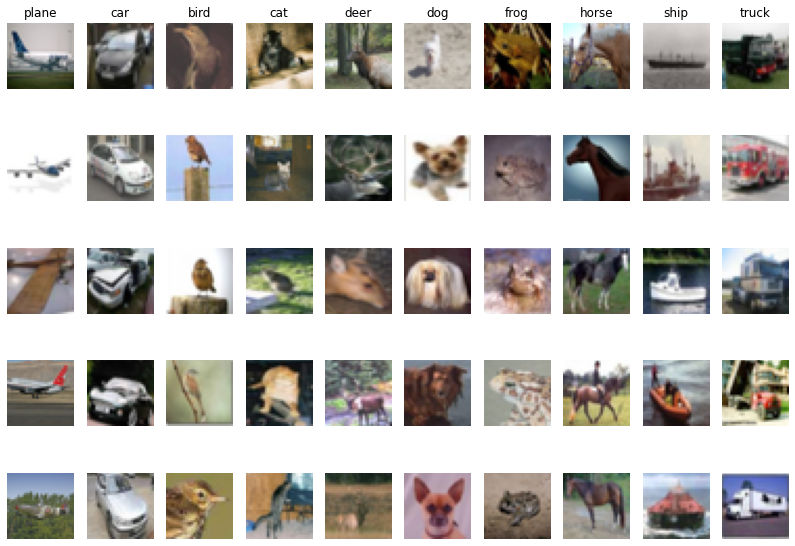

In [7]:
data_non_tensor = torchvision.datasets.CIFAR10('.', train=True) # this variable will not be used

num_visualize = 5

for i in range(len(classes)):
    chosen = np.random.choice(indices_of_class_i[i], num_visualize, replace=False)
    for j in range(num_visualize):
        plt.subplot(num_visualize, len(classes), 1 + (j * len(classes)) + i)
        plt.imshow(np.asarray(data_non_tensor[chosen[j]][0]))
        plt.axis('off')
        if j == 0:
            plt.title(number_to_class[i])
plt.show()
      

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [4]:
class ResBlock(nn.Module):
    def __init__(self, change, chin, chout):
        super().__init__()
        self.change = change
        if change:
            self.conv1 = nn.Conv2d(chin, chout, 3, padding = 1, stride = 2, bias = False)
            self.conv2 = nn.Conv2d(chout, chout, 3, padding = 1, bias = False)
            self.conv3  =nn.Conv2d(chin, chout, 1, stride = 2, bias = False)
        
        else:
            self.conv1 = nn.Conv2d(chin, chout, 3, padding = 1, bias = False)
            self.conv2 = nn.Conv2d(chout, chout, 3, padding = 1, bias = False)
            self.conv3  =nn.Conv2d(chin, chout, 1, stride = 1, bias = False)
        
        self.bn1 = nn.BatchNorm2d(chout)
        self.bn2 = nn.BatchNorm2d(chout)
        self.bn3 = nn.BatchNorm2d(chout)
        self.rl = F.relu
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.rl(out)
        out = self.conv2(out)
        out = self.bn2(out)
        x = self.conv3(x)
        x = self.bn3(x)
        out += x
        out = self.rl(out)
        return out
    
class NET(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1, stride = 1, bias =False)
        self.ap = nn.AvgPool2d(3, padding = 1, stride = 2)
        self.fl = nn.Flatten()
        self.fcfinal = nn.Linear(512, 10)
        self.bn = nn.BatchNorm2d(16)
        
        self.rs1 = ResBlock(False, 16, 32)
        self.mp1 = nn.MaxPool2d(2)
        self.rs2 = ResBlock(False, 32, 64)
        self.mp2 = nn.MaxPool2d(2)
        self.rs3 = ResBlock(False, 64, 128)
        self.mp3 = nn.MaxPool2d(2)
        self.rs4 = ResBlock(False, 128, 256)
        self.mp4 = nn.MaxPool2d(2)
        self.rs5 = ResBlock(False, 256, 512)
        self.rl = F.relu
        
        self.do = nn.Dropout1d(0.25)

    def forward(self, out):
        # out B, 3, 32, 32
        out = self.conv1(out) # B, 16, 32, 32
        out = self.bn(out)
        out = self.rl(out)
        out = self.rs1(out) # B, 32, 32, 32
        out = self.mp1(out) # B, 32, 16, 16
        out = self.rs2(out) # B, 128, 16, 16
        out = self.mp2(out) # B, 128, 8, 8
        out = self.rs3(out) # B, 128, 8, 8
        out = self.mp3(out) # B, 128, 4, 4 
        out = self.rs4(out) # B, 256, 4, 4
        out = self.mp4(out) # B, 256, 2, 2
        out = self.rs5(out) # B, 512, 2, 2
        out = self.ap(out) # B, 512, 1, 1
        out = self.fl(out) # B, 512
        out = self.do(out)
        out = self.fcfinal(out) # B, 10
        
        return out

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [151]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
dev

'cuda'

In [10]:
net = NET().to(dev)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [13]:
criterion = nn.CrossEntropyLoss().to(dev)
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1, weight_decay=0.001)

scheduler1 = torch.optim.lr_scheduler.ConstantLR(optimizer, factor = 1, total_iters=50)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.987, )
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[50])

[0.04001296063800412]


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.

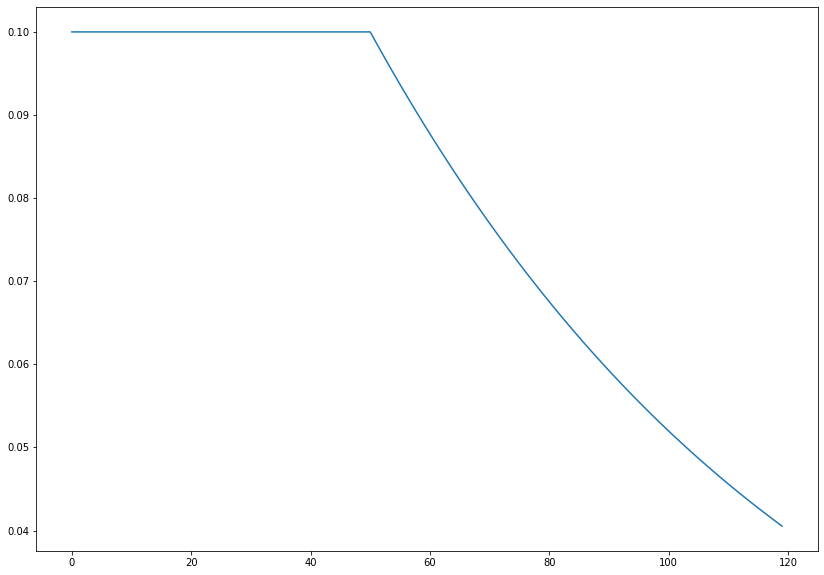

In [12]:
epochs = 120
lrs = []
for i in range(epochs):
    temp = optimizer.state_dict()
    lrs.append(temp['param_groups'][0]['lr'])
    scheduler.step()
print(scheduler.get_last_lr())
plt.plot(lrs)

# alpha decay

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [14]:
s = 0
for i in net.named_parameters():
    s += i[1].reshape(-1).shape[0]
print(s)

4900122


In [15]:
epochs = 120

trainloss = []
valloss = []
trainacc = []
valacc = []

# tloader
# vloader

for epoch in range(epochs):
    loss = 0
    seen = 0
    correct = 0
    net.train()
    for i in tloader:
        
        x = i[0].to(dev)
        y = i[1].to(dev)
        
        optimizer.zero_grad()
        out = net(x)
        criout = criterion(out, y)
        loss += float(criout)
        
        out = out.argmax(-1)
        correct += sum(out == y)
        seen += len(y)
        
        criout.backward()
        optimizer.step()
        
    trainloss.append(loss)
    trainacc.append(correct/seen)
    loss = 0
    seen = 0
    correct = 0
    net.eval()
    with torch.no_grad():
        for i in vloader:
            x = i[0].to(dev)
            y = i[1].to(dev)

            out = net(x)
            criout = criterion(out, y)
            loss += float(criout)

            out = out.argmax(-1)
            correct += sum(out == y)
            seen += len(y)

        valloss.append(loss)
        valacc.append(correct/seen)
    scheduler.step()
    
    print(f'epoch {epoch + 1:3d} , train loss {trainloss[epoch]:5.5f}, train acc {trainacc[epoch]:.3f}, val loss {valloss[epoch]:5.5f}, val acc {valacc[epoch]:.3f}, lr : {optimizer.state_dict()["param_groups"][0]["lr"]}')

torch.save(net.state_dict(), 'aftersomanytries12.pth')


epoch   1 , train loss 561.74362, train acc 0.400, val loss 6.98261, val acc 0.521, lr : 0.1
epoch   2 , train loss 451.12119, train acc 0.521, val loss 5.78424, val acc 0.599, lr : 0.1
epoch   3 , train loss 405.71473, train acc 0.570, val loss 4.56589, val acc 0.685, lr : 0.1
epoch   5 , train loss 363.03586, train acc 0.615, val loss 4.18089, val acc 0.703, lr : 0.1
epoch   6 , train loss 347.48013, train acc 0.632, val loss 3.85816, val acc 0.734, lr : 0.1
epoch   7 , train loss 334.65086, train acc 0.645, val loss 3.55649, val acc 0.751, lr : 0.1
epoch   8 , train loss 327.06878, train acc 0.653, val loss 3.66294, val acc 0.750, lr : 0.1
epoch   9 , train loss 315.03104, train acc 0.666, val loss 3.96145, val acc 0.720, lr : 0.1
epoch  10 , train loss 312.71956, train acc 0.668, val loss 3.97446, val acc 0.727, lr : 0.1
epoch  11 , train loss 304.02745, train acc 0.677, val loss 3.76794, val acc 0.733, lr : 0.1
epoch  12 , train loss 298.96929, train acc 0.679, val loss 3.40693, v

In [17]:
# run for a few more epochs

for epoch in range(60):
    loss = 0
    seen = 0
    correct = 0
    net.train()
    for i in tloader:
        
        x = i[0].to(dev)
        y = i[1].to(dev)
        
        optimizer.zero_grad()
        out = net(x)
        criout = criterion(out, y)
        loss += float(criout)
        
        out = out.argmax(-1)
        correct += sum(out == y)
        seen += len(y)
        
        criout.backward()
        optimizer.step()
        
    trainloss.append(loss)
    trainacc.append(correct/seen)
    loss = 0
    seen = 0
    correct = 0
    net.eval()
    with torch.no_grad():
        for i in vloader:
            x = i[0].to(dev)
            y = i[1].to(dev)

            out = net(x)
            criout = criterion(out, y)
            loss += float(criout)

            out = out.argmax(-1)
            correct += sum(out == y)
            seen += len(y)

        valloss.append(loss)
        valacc.append(correct/seen)
    scheduler.step()

    print(f'epoch {epoch + 121:3d} , train loss {trainloss[epoch + 120]:5.5f}, train acc {trainacc[epoch + 120]:.3f}, val loss {valloss[epoch + 120]:5.5f}, val acc {valacc[epoch + 120]:.3f}, lr : {optimizer.state_dict()["param_groups"][0]["lr"]}')

torch.save(net.state_dict(), 'aftersomanytries13.pth')



epoch 121 , train loss 210.61064, train acc 0.770, val loss 2.26305, val acc 0.861, lr : 0.03949279214971007
epoch 122 , train loss 211.69461, train acc 0.768, val loss 2.25417, val acc 0.858, lr : 0.03897938585176384
epoch 123 , train loss 213.09964, train acc 0.768, val loss 2.17166, val acc 0.868, lr : 0.03847265383569091
epoch 124 , train loss 213.18986, train acc 0.767, val loss 2.38940, val acc 0.853, lr : 0.03797250933582692
epoch 125 , train loss 209.72337, train acc 0.770, val loss 2.24423, val acc 0.861, lr : 0.03747886671446117
epoch 126 , train loss 209.71516, train acc 0.771, val loss 2.36845, val acc 0.851, lr : 0.03699164144717317
epoch 127 , train loss 210.45283, train acc 0.771, val loss 3.09690, val acc 0.812, lr : 0.03651075010835992
epoch 128 , train loss 209.53307, train acc 0.771, val loss 2.25733, val acc 0.867, lr : 0.03603611035695124
epoch 129 , train loss 214.03165, train acc 0.766, val loss 2.25030, val acc 0.860, lr : 0.03556764092231088
epoch 130 , train l

In [20]:
seen = 0
correct = 0
net.eval()
for i, (x, y) in enumerate(testloader):
    x = x.to(dev)
    y = y.to(dev)

    out = net(x)
    criout = criterion(out, y)

    out = out.argmax(-1)
    correct += sum(out == y)
    seen += len(y)

print(correct/seen)

tensor(0.8801, device='cuda:0')


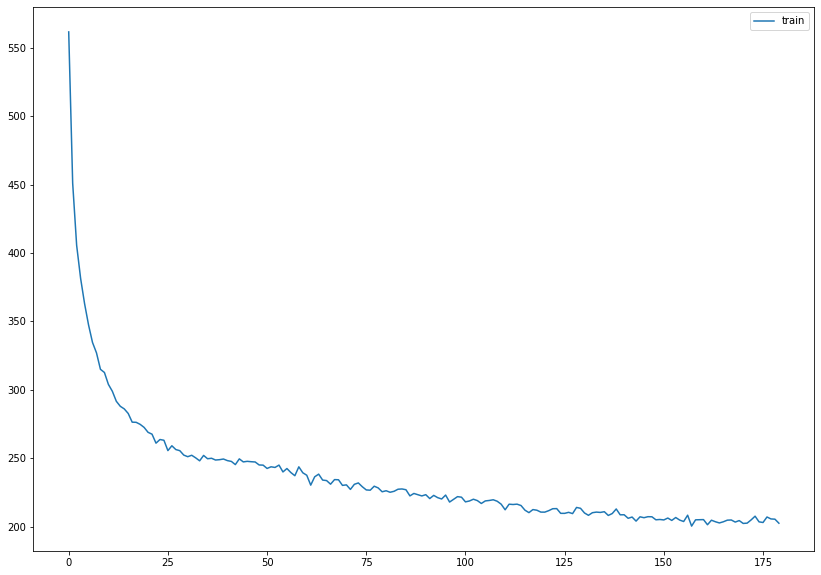

In [21]:
plt.plot(trainloss)
plt.legend(['train'])

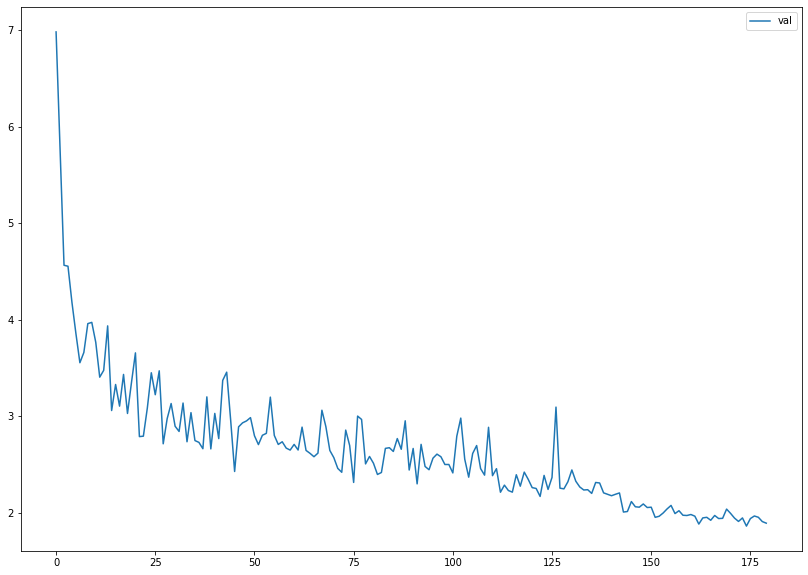

In [22]:
plt.plot(valloss)
plt.legend(['val'])

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [29]:
# suppose the net is ready to be used

def imagetransform(x):
    x = torchvision.transforms.RandomChoice([torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.RandomVerticalFlip(), lambda y : y])(x)
    return torchvision.transforms.Normalize([0.49139968,  0.48215841,  0.44653091], [0.24703223,  0.24348513,  0.26158784])(torchvision.transforms.ToTensor()(x))

net = NET()
net.load_state_dict(torch.load('aftersomanytries13.pth'))

fulloutput = None
fulloutput_labels = None
full_preditions = None

def forhook(m, i, o):
    global fulloutput
    fulloutput = i

data = torchvision.datasets.CIFAR10('.', download=True, train=True, transform=imagetransform)
net.eval()
net.to('cpu')
net.fcfinal.register_forward_hook(forhook)
with torch.no_grad():
    fulldataloader = torch.utils.data.DataLoader(data, batch_size=50000, shuffle=False)
    for i in fulldataloader:
        x = i[0]
        y = i[1]

        fulloutput_labels = y
        full_preditions = net(x) # stored in full output
    
    
        break

Files already downloaded and verified


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

In [120]:
arr = []
while len(arr) < 24:
    idx = np.random.randint(10000)
    if y[idx] != np.argmax(p[idx]):
        arr.append(idx)

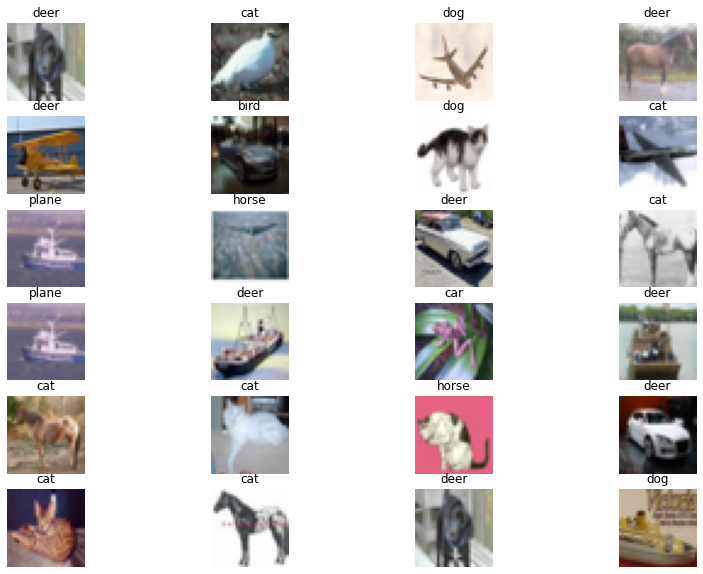

In [121]:
for i in range(24):
    plt.subplot(6, 4, i + 1)
    plt.imshow(data_imgtest[arr[i]][0])
    plt.title(number_to_class[np.argmax(p[arr[i]]).item()])
    plt.axis('off')

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

In [41]:
fulloutputnew = fulloutput

In [42]:
fulloutput_labelsnew = fulloutput_labels

In [43]:
fullpredicionsnew = full_preditions

In [51]:
    
def justnormalize(x):
    return torchvision.transforms.Normalize([0.49139968,  0.48215841,  0.44653091], [0.24703223,  0.24348513,  0.26158784])(torchvision.transforms.ToTensor()(x))

testsetFS = None

def fchook(m, i, o):
    global testsetFS
    testsetFS = i[0]

datatest = torchvision.datasets.CIFAR10('.', download=True, train=False, transform=justnormalize)
net.eval()
net.to('cpu')
y = None
p = None
net.fcfinal.register_forward_hook(fchook)
with torch.no_grad():
    fulldataloader = torch.utils.data.DataLoader(data, batch_size=10000, shuffle=False)
    for i in fulldataloader:
        x = i[0]
        y = i[1]

        p = net(x) # stored in full output
    
    
        break
        



Files already downloaded and verified


In [109]:

arr = []
while len(arr) < 5:
    idx = np.random.randint(10000)
    if y[idx] == np.argmax(p[idx]):
        arr.append(idx)



Files already downloaded and verified
Files already downloaded and verified


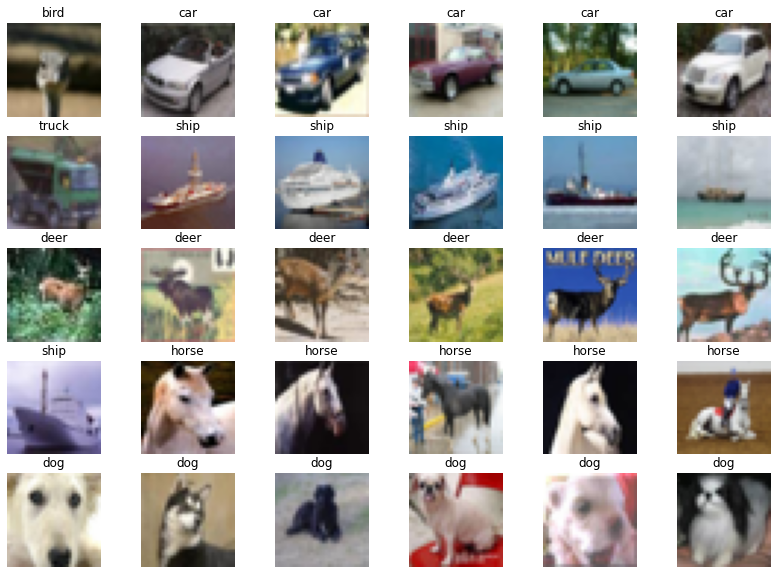

In [110]:
data_img = torchvision.datasets.CIFAR10('.', download=True, train=True)
data_imgtest = torchvision.datasets.CIFAR10('.', download=True, train=False)
for i, idx in enumerate(arr):
    plt.subplot(5, 6, 1 + (6*i))
    plt.imshow(data_imgtest[idx][0])
    plt.title(number_to_class[data_imgtest[idx][1]])
    plt.axis('off')
    for j, k in enumerate(torch.topk(((fulloutputnew - testsetFS[idx])**2).sum(1), 5, largest=False)[1]):
        plt.subplot(5, 6, 2 + (6*i) + j)
        plt.imshow(data_img[k][0])
        plt.title(number_to_class[data_img[k][1]])
        plt.axis('off')
    


1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [111]:
from sklearn.manifold import TSNE

In [131]:
indices = np.random.randint(0, 10000, 2000)
arr2d = TSNE(init='pca').fit_transform(fulloutputnew[indices])

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

In [132]:
arr2d.shape

(2000, 2)

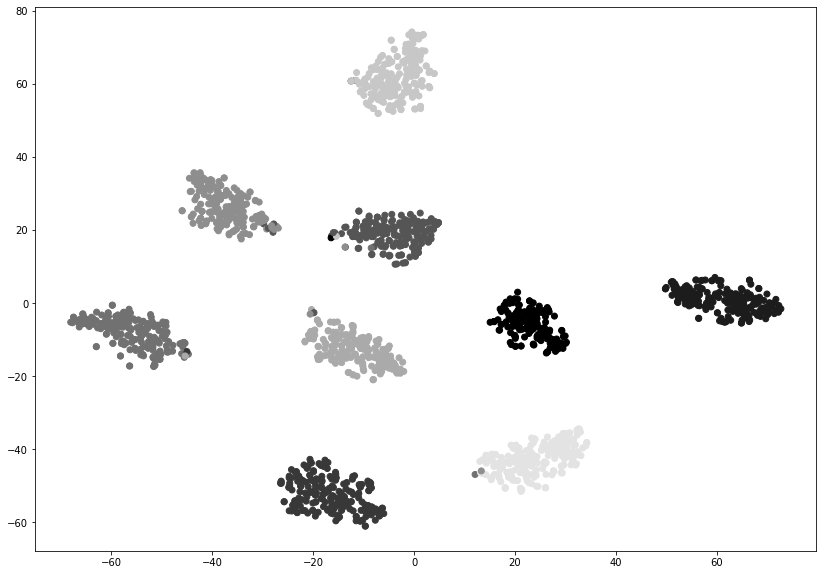

In [142]:
plt.scatter(arr2d[:, 0], arr2d[:, 1], c = [i.item() for i in fulloutput_labelsnew[indices]])

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [143]:
from PIL import Image
from torchvision import transforms

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [147]:
class rgb_bw_cifar10(torch.utils.data.Dataset):
    
    def __init__(self):
        self.datanormal = torchvision.datasets.CIFAR10('.', download=True, train=True, transform=justnormalize)
        self.data_bw = [transforms.Grayscale(1)(self.datanormal[i][0]).reshape(-1, 32) for i in range(len(self.datanormal))]
        
    def __len__(self):
        return len(self.datanormal)

    def __getitem__(self, idx):
        return (self.data_bw[idx], self.datanormal[idx][1], self.datanormal[idx][0]) 

    


Files already downloaded and verified
Files already downloaded and verified


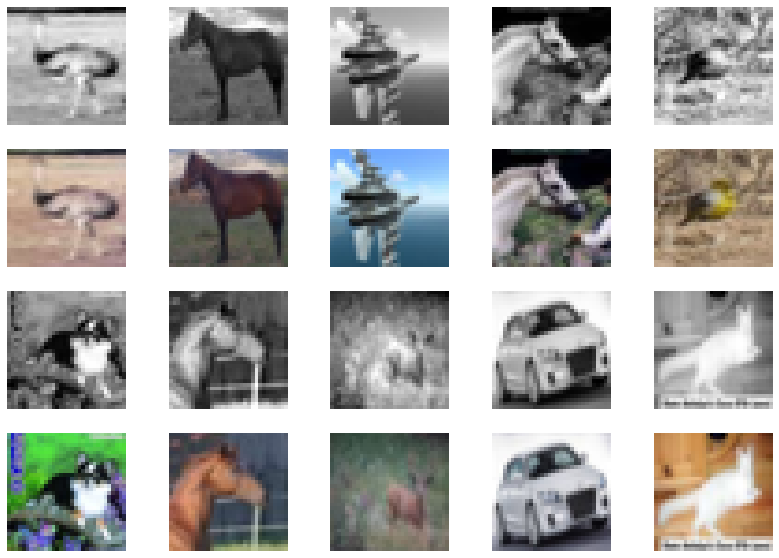

In [148]:
databw = rgb_bw_cifar10()
data_temp = torchvision.datasets.CIFAR10('.', download=True, train=True)

chosen = np.random.choice([i for i in range(len(databw))], 10, replace = False)
for i in range(10):
    if i < 5:
        plt.subplot(4, 5, 1 + i)
        plt.imshow(databw[chosen[i]][0])
        plt.axis('off')
        
        plt.subplot(4, 5, 6 + i)
        plt.imshow(data_temp[chosen[i]][0])
        plt.axis('off')
    
    else:
        plt.subplot(4, 5, 6 + i)
        plt.imshow(databw[chosen[i]][0])
        plt.axis('off')
        
        plt.subplot(4, 5, 11 + i)
        plt.imshow(np.asarray(data_temp[chosen[i]][0]))
        plt.axis('off')
    
plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [149]:
class NET_COL(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.unfl = nn.Unflatten(1, (1, 32))
        self.conv1 = nn.Conv2d(1, 64, 3, padding = 1, stride = 1, bias=False)
        self.conv11 = nn.Conv2d(64, 64, 3, padding = 1, stride = 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64, 3, padding = 1, stride = 1, bias=False)
        self.conv21 = nn.Conv2d(128, 64, 3, padding = 1, stride = 1, bias=False)
        self.conv22 = nn.Conv2d(64, 64, 3, padding = 1, stride = 1, bias=False)
        self.rl = F.relu
        self.bn1 = nn.BatchNorm2d(64)
        self.bn11 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1, stride = 2, bias=False)
        self.conv31 = nn.Conv2d(128, 128, 3, padding = 1, stride = 1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1, stride = 1, bias=False)
        self.conv41 = nn.Conv2d(256, 128, 3, padding = 1, stride = 1, bias=False)
        self.conv42 = nn.Conv2d(128, 128, 3, padding = 1, stride = 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn21 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1, stride = 2, bias=False)
        self.conv51 = nn.Conv2d(256, 256, 3, padding = 1, stride = 1, bias=False)
        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1, stride = 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.convT1 = nn.ConvTranspose2d(256, 128, 3, stride = 2, padding = 1, output_padding = 1, bias=False)
        self.convT2 = nn.ConvTranspose2d(128, 64, 3, stride = 2, padding = 1, output_padding = 1, bias=False)
        self.conv7 = nn.Conv2d(64, 3, 3, padding = 1, stride = 1, bias=False)
        self.ap = nn.AvgPool2d(3, padding = 1, stride = 1)

    def forward(self, out):
        # out B, 32, 32
        out = self.unfl(out) # B, 1, 32, 32
        
        out = self.conv1(out) # B, 64, 32, 32
        out = self.rl(out)
        out = self.conv11(out) # B, 64, 32, 32
        out = self.rl(out)
        out = self.conv2(out) # B, 64, 32, 32
        out = self.bn1(out)
        out = self.rl(out)
        temp = out # B, 64, 32, 32
        
        out = self.conv3(out) # B, 128, 16, 16
        out = self.rl(out)
        out = self.conv31(out) # B, 128, 16, 16
        out = self.conv4(out) # B, 128, 16, 16
        out = self.bn2(out)
        out = self.rl(out)
        temp1 = out # B, 128, 16, 16
        
        out = self.conv5(out) # B, 256, 8, 8
        out = self.rl(out)
        out = self.conv51(out) # B, 256, 8, 8
        out = self.rl(out)
        out = self.conv6(out) # B, 256, 8, 8
        out = self.bn3(out)
        out = self.rl(out)
        out = self.ap(out)
        
        out = self.convT1(out) # B, 128, 16, 16
        out = torch.cat([out, temp1], 1) # B, 256, 16, 16
        out = self.conv41(out) # B, 128, 16, 16
        out = self.rl(out)
        out = self.conv42(out) # B, 128, 16, 16
        out = self.bn21(out)
        out = self.rl(out)
        
        out = self.convT2(out) # B, 64, 32, 32
        out = torch.cat([out, temp], 1) # B, 128, 32, 32
        out = self.conv21(out) # B, 64, 32, 32
        out = self.rl(out)
        out = self.conv22(out) # B, 64, 32, 32
        out = self.bn11(out)
        out = self.rl(out)
        
        out = self.conv7(out) # B, 3, 32, 32
        return out

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [162]:

net_col = NET_COL().to(dev)

s = 0
for i in net_col.named_parameters():
    s += i[1].reshape(-1).shape[0]
print(s)

criterion = nn.L1Loss().to(dev)
optimizer = torch.optim.SGD(net_col.parameters(), lr = 0.025, weight_decay=0.001)

scheduler1 = torch.optim.lr_scheduler.ConstantLR(optimizer, factor = 1, total_iters=20)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.966, )
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[20])


l = len(data) 
trainset, valset = torch.utils.data.random_split(databw, (l - (l//10), l//10))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024, shuffle=False)
testdata_col = torchvision.datasets.CIFAR10('.', download=True, train=False, transform=justnormalize)
testloader_col = torch.utils.data.DataLoader(testdata_col, batch_size=1024, shuffle=False)

2842112
Files already downloaded and verified


In [163]:

epochs = 50

trainloss_col = []
valloss_col = []

# tloader
# vloader


for epoch in range(epochs):
    loss = 0
    net_col.train()
    for i in trainloader:
        
        x = i[0].to(dev)
        y = i[2].to(dev)
        
        optimizer.zero_grad()
        out = net_col(x)
        
        criout = criterion(out, y)
        loss += float(criout)
        
        criout.backward()
        optimizer.step()
        
    trainloss_col.append(loss)
    loss = 0
    net.eval()
    with torch.no_grad():
        for i in valloader:
            x = i[0].to(dev)
            y = i[2].to(dev)

            out = net_col(x)
            criout = criterion(out, y)
            loss += float(criout)


        valloss_col.append(loss)
    
    print(f'epoch {epoch + 1} , train loss {trainloss_col[epoch]:.5f}, val loss {valloss_col[epoch]:.5f}, lr {optimizer.state_dict()["param_groups"][0]["lr"]}')



epoch 1 , train loss 104.95585, val loss 1.24834, lr 0.025
epoch 2 , train loss 88.32434, val loss 1.12429, lr 0.025
epoch 3 , train loss 81.26238, val loss 1.18922, lr 0.025
epoch 4 , train loss 78.15605, val loss 1.06478, lr 0.025
epoch 5 , train loss 75.80961, val loss 1.00176, lr 0.025
epoch 6 , train loss 73.07697, val loss 1.02094, lr 0.025
epoch 7 , train loss 72.38423, val loss 0.98024, lr 0.025
epoch 8 , train loss 71.33096, val loss 1.01512, lr 0.025
epoch 9 , train loss 70.29406, val loss 0.96078, lr 0.025
epoch 10 , train loss 69.73718, val loss 0.92609, lr 0.025
epoch 11 , train loss 68.99189, val loss 0.95621, lr 0.025
epoch 12 , train loss 69.18770, val loss 0.92232, lr 0.025
epoch 13 , train loss 68.56871, val loss 0.91135, lr 0.025
epoch 14 , train loss 67.87054, val loss 0.98274, lr 0.025
epoch 15 , train loss 67.45767, val loss 1.01366, lr 0.025
epoch 16 , train loss 67.30497, val loss 0.90435, lr 0.025
epoch 17 , train loss 67.12116, val loss 0.92862, lr 0.025
epoch

KeyboardInterrupt: 

In [166]:
scheduler1 = torch.optim.lr_scheduler.ConstantLR(optimizer, factor = 1, total_iters=20)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.92, )
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[1])

for epoch in range(epochs):
    loss = 0
    net_col.train()
    for i in trainloader:
        
        x = i[0].to(dev)
        y = i[2].to(dev)
        
        optimizer.zero_grad()
        out = net_col(x)
        
        criout = criterion(out, y)
        loss += float(criout)
        
        criout.backward()
        optimizer.step()
        
    trainloss_col.append(loss)
    loss = 0
    net.eval()
    with torch.no_grad():
        for i in valloader:
            x = i[0].to(dev)
            y = i[2].to(dev)

            out = net_col(x)
            criout = criterion(out, y)
            loss += float(criout)


        valloss_col.append(loss)
    scheduler.step()
    
    print(f'epoch {epoch + 38} , train loss {trainloss_col[epoch + 37]:.5f}, val loss {valloss_col[epoch + 37]:.5f}, lr {optimizer.state_dict()["param_groups"][0]["lr"]}')



/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 38 , train loss 62.81106, val loss 0.89947, lr 0.025
epoch 39 , train loss 62.35114, val loss 0.96156, lr 0.023000000000000003
epoch 40 , train loss 61.70305, val loss 0.88011, lr 0.021160000000000005
epoch 41 , train loss 60.97535, val loss 0.90221, lr 0.019467200000000004
epoch 42 , train loss 60.57663, val loss 0.90644, lr 0.017909824000000005
epoch 43 , train loss 59.85753, val loss 0.88812, lr 0.016477038080000006
epoch 44 , train loss 59.22996, val loss 0.90279, lr 0.015158875033600007
epoch 45 , train loss 58.57877, val loss 0.89603, lr 0.013946165030912007
epoch 46 , train loss 57.95745, val loss 0.91500, lr 0.012830471828439048
epoch 47 , train loss 57.13052, val loss 0.94190, lr 0.011804034082163925
epoch 48 , train loss 56.62507, val loss 0.94189, lr 0.010859711355590811
epoch 49 , train loss 55.85151, val loss 0.91069, lr 0.009990934447143546
epoch 50 , train loss 55.33335, val loss 0.90535, lr 0.009191659691372063
epoch 51 , train loss 54.80894, val loss 0.93486, lr 

KeyboardInterrupt: 

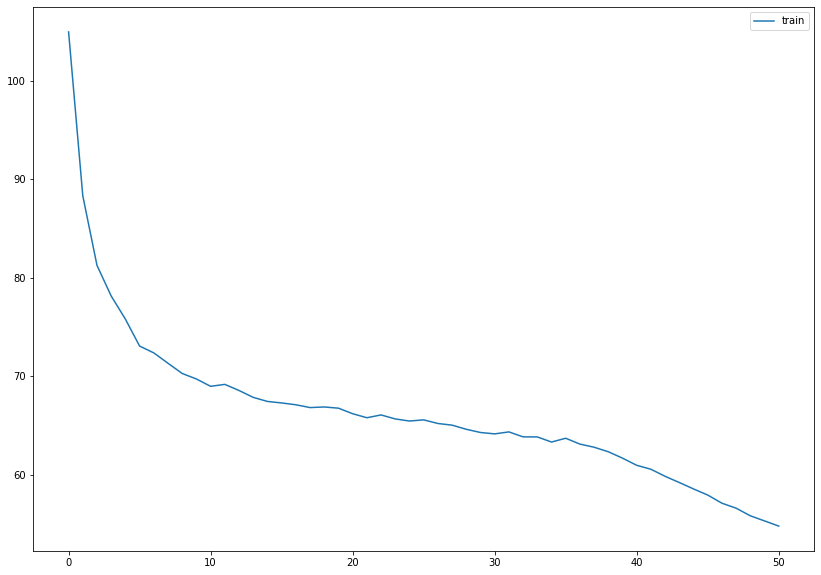

In [167]:
plt.plot(trainloss_col)
plt.legend(['train'])

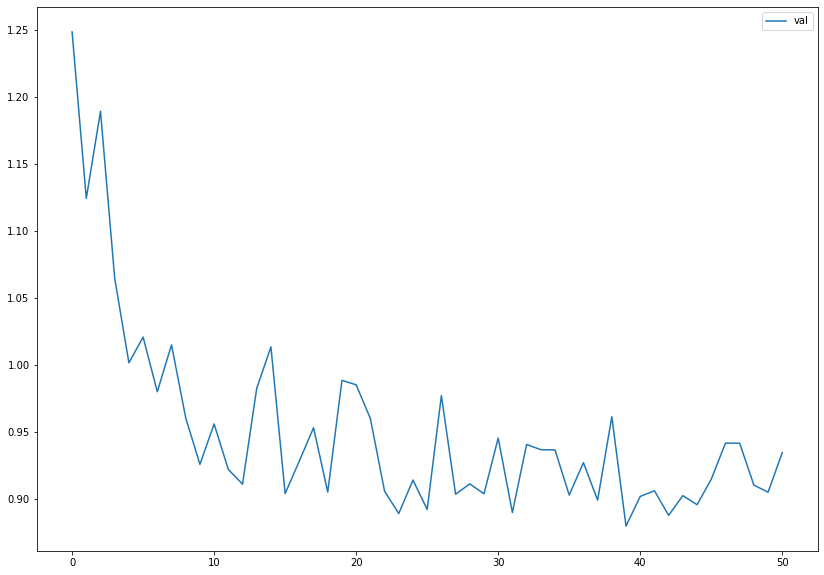

In [168]:
plt.plot(valloss_col)
plt.legend(['val'])

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [169]:
class rgb_bw_cifar10_test(torch.utils.data.Dataset):
    def __init__(self):
        self.datanormal = torchvision.datasets.CIFAR10('.', download=True, train=False, transform=justnormalize)
        self.data_bw = [transforms.Grayscale(1)(self.datanormal[i][0]).reshape(-1, 32) for i in range(len(self.datanormal))]
        
    def __len__(self):
        return len(self.datanormal)

    def __getitem__(self, idx):
        return (self.data_bw[idx], self.datanormal[idx][1], self.datanormal[idx][0]) 
    
data_test_col = rgb_bw_cifar10_test()
tensor_to_image = transforms.ToPILImage()

def denormalize(x):
    x = torchvision.transforms.Normalize([0.0,  0.0,  0.0], [1/0.24703223,  1/0.24348513,  1/0.26158784])(x)
    return torchvision.transforms.Normalize([-0.49139968,  -0.48215841,  -0.44653091], [1.0,  1.0,  1.0])(x)

Files already downloaded and verified


In [185]:
chosen = np.random.choice([i for i in range(len(data_test_col))], 36, replace=False)

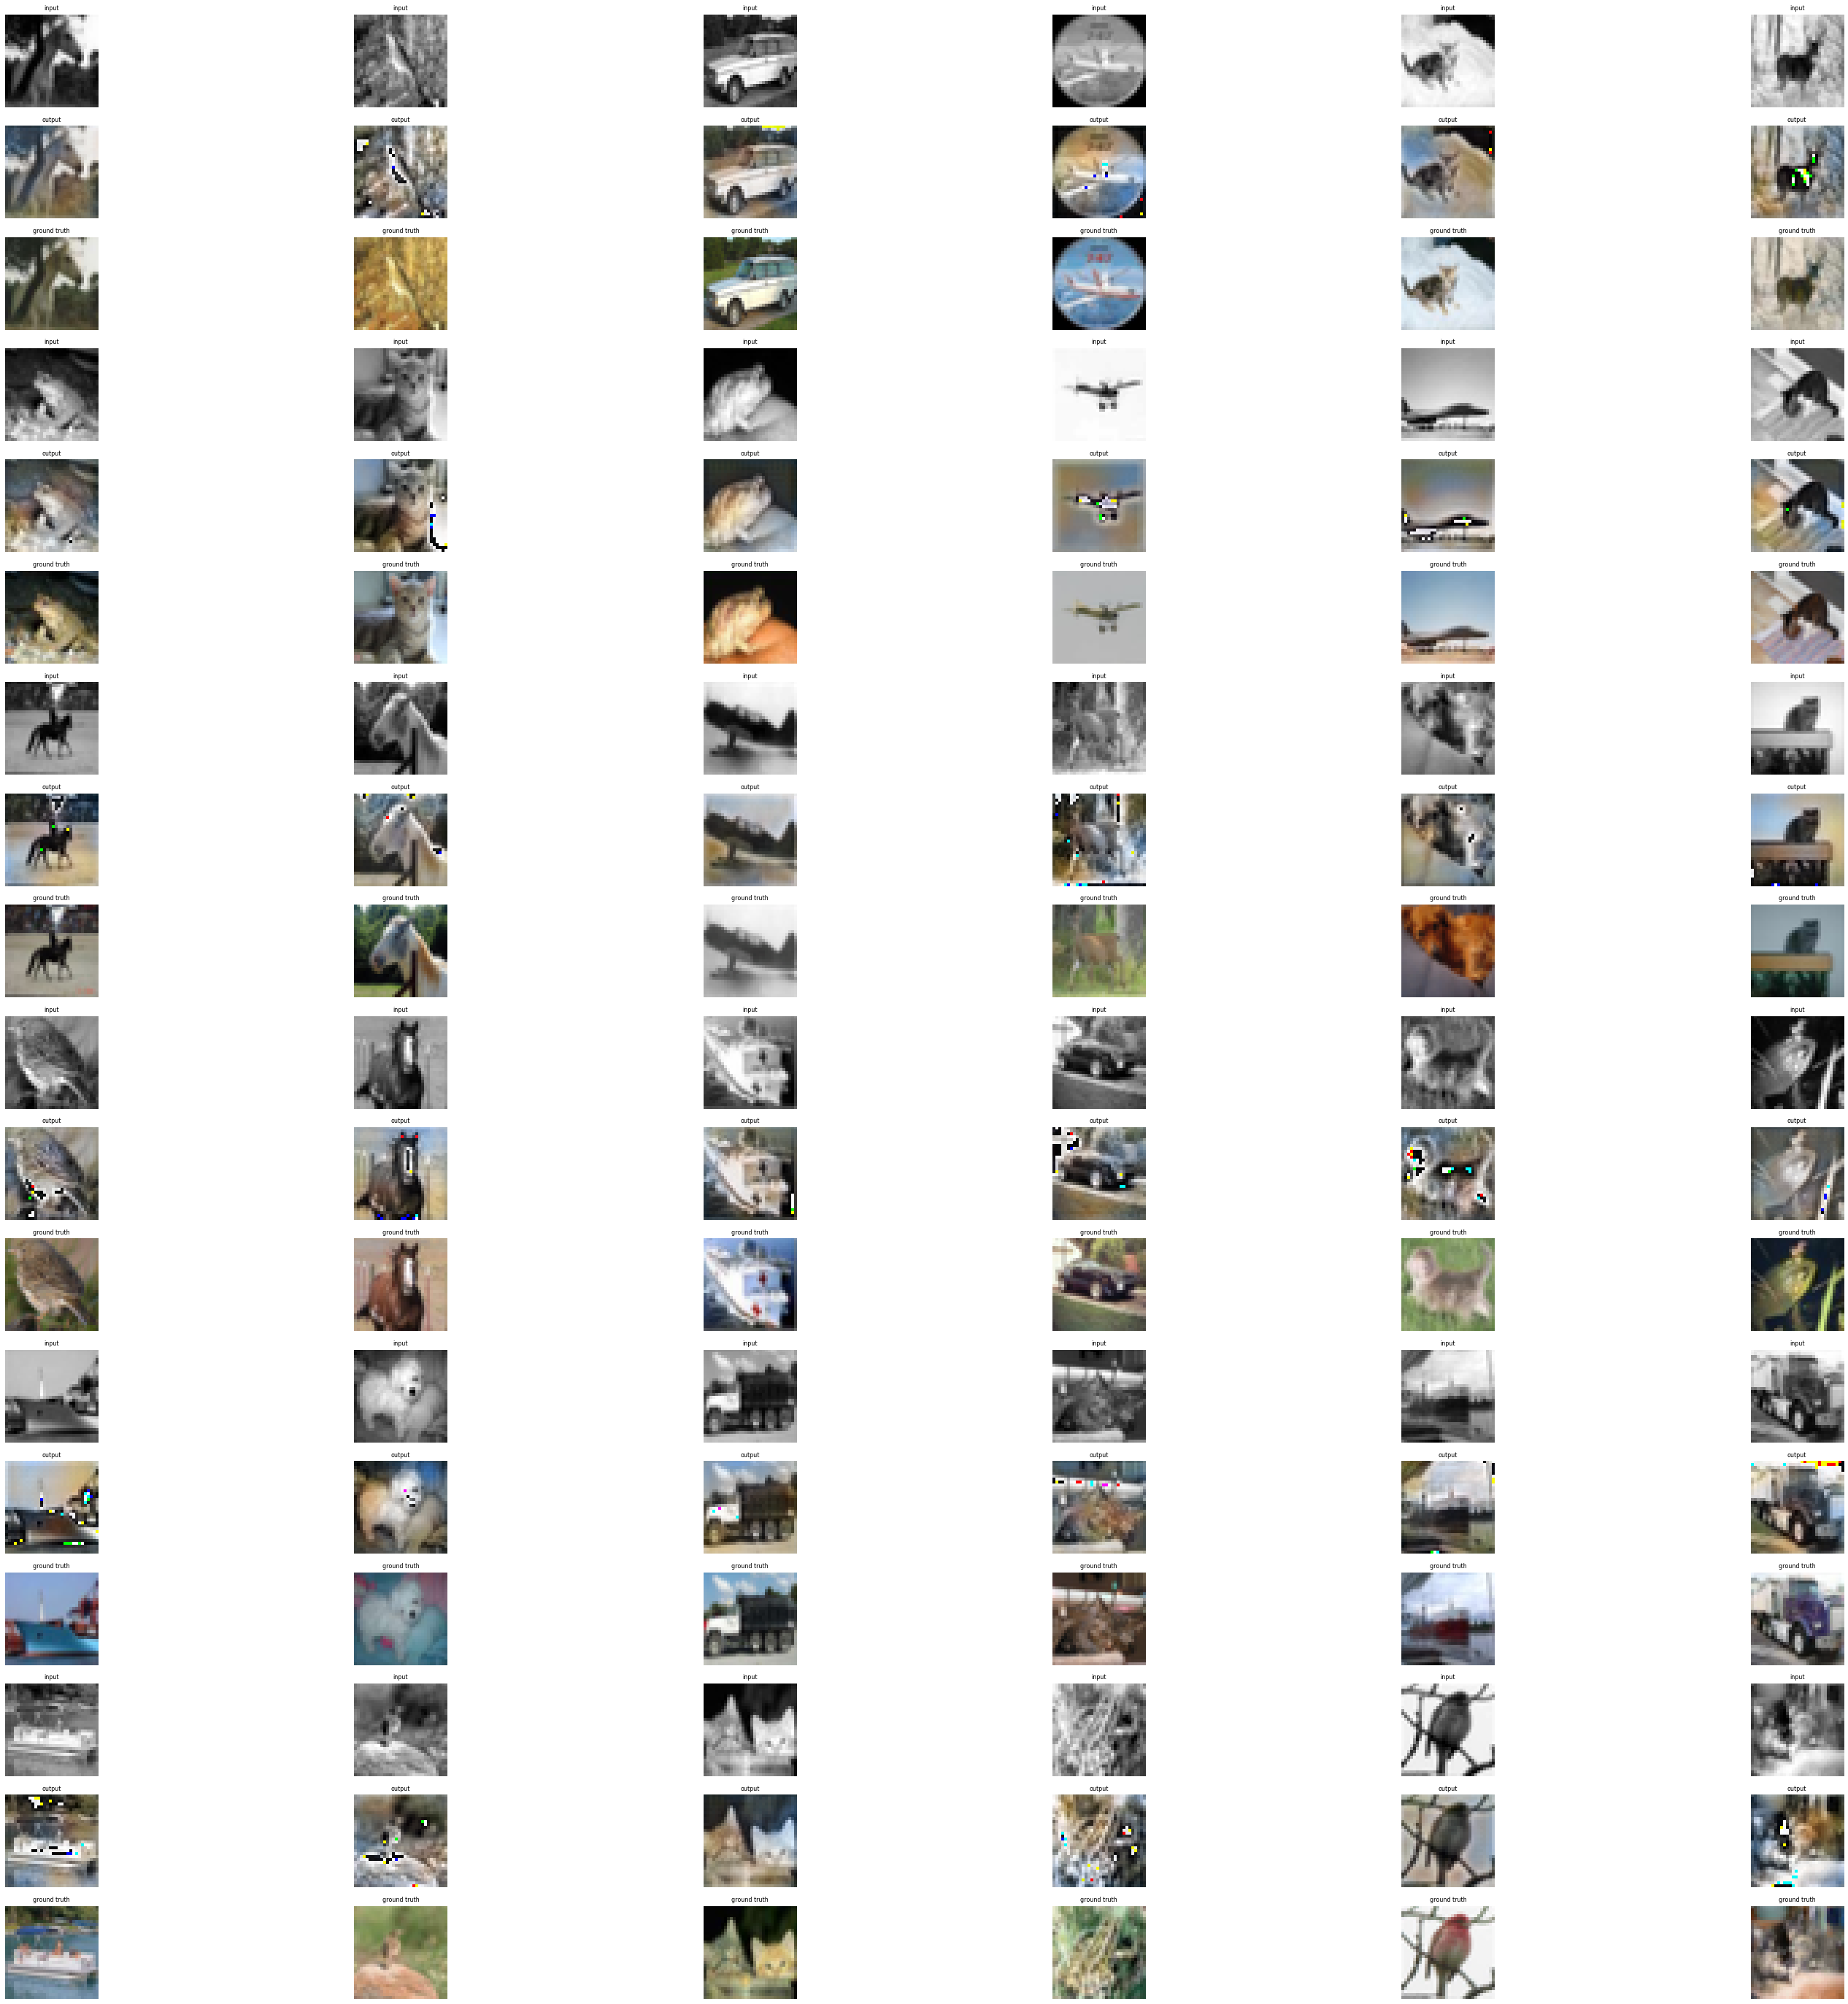

In [186]:
# edit configs
plt.rcParams['figure.figsize'] = (50, 50)

for num, i in enumerate(chosen):
    x = data_test_col[i][0]
    gt = tensor_to_image(denormalize(data_test_col[i][2]))
    
    out = tensor_to_image(denormalize(net_col(data_test_col[i][0].reshape(-1, 32, 32).to(dev)).reshape(3, 32, 32)))
    
    if num < 6:
        plt.subplot(18, 6, 1 + num)
        plt.imshow(x)
        plt.axis('off')
        plt.title('input', size = 8)
        
        plt.subplot(18, 6, 7 + num)
        plt.imshow(out)
        plt.axis('off')
        plt.title('output', size = 8)
        
        plt.subplot(18, 6, 13 + num)
        plt.imshow(gt)
        plt.axis('off')
        plt.title('ground truth', size = 8)
    
    elif num < 12:
        plt.subplot(18, 6, 13 + num)
        plt.imshow(x)
        plt.axis('off')
        plt.title('input', size = 8)
        
        plt.subplot(18, 6, 19 + num)
        plt.imshow(out)
        plt.axis('off')
        plt.title('output', size = 8)
        
        plt.subplot(18, 6, 25 + num)
        plt.imshow(gt)
        plt.axis('off')
        plt.title('ground truth', size = 8)
    
    elif num < 18:
        plt.subplot(18, 6, 25 + num)
        plt.imshow(x)
        plt.axis('off')
        plt.title('input', size = 8)
        
        plt.subplot(18, 6, 31 + num)
        plt.imshow(out)
        plt.axis('off')
        plt.title('output', size = 8)
        
        plt.subplot(18, 6, 37 + num)
        plt.imshow(gt)
        plt.axis('off')
        plt.title('ground truth', size = 8)
        
    elif num < 24:
        plt.subplot(18, 6, 37 + num)
        plt.imshow(x)
        plt.axis('off')
        plt.title('input', size = 8)
        
        plt.subplot(18, 6, 43 + num)
        plt.imshow(out)
        plt.axis('off')
        plt.title('output', size = 8)
        
        plt.subplot(18, 6, 49 + num)
        plt.imshow(gt)
        plt.axis('off')
        plt.title('ground truth', size = 8)
    
    elif num < 30:
        plt.subplot(18, 6, 49 + num)
        plt.imshow(x)
        plt.axis('off')
        plt.title('input', size = 8)
        
        plt.subplot(18, 6, 55 + num)
        plt.imshow(out)
        plt.axis('off')
        plt.title('output', size = 8)
        
        plt.subplot(18, 6, 61 + num)
        plt.imshow(gt)
        plt.axis('off')
        plt.title('ground truth', size = 8)
    
    else:
        plt.subplot(18, 6, 61 + num)
        plt.imshow(x)
        plt.axis('off')
        plt.title('input', size = 8)
        
        plt.subplot(18, 6, 67 + num)
        plt.imshow(out)
        plt.axis('off')
        plt.title('output', size = 8)
        
        plt.subplot(18, 6, 73 + num)
        plt.imshow(gt)
        plt.axis('off')
        plt.title('ground truth', size = 8)



In [187]:
torch.save(net.state_dict(), 'col_net3.pth')